In [1]:
from  AlgoTools import *

import os
from dotenv import load_dotenv
from oandapyV20 import API
import oandapyV20.endpoints.trades as trades
import oandapyV20.endpoints.accounts as accounts
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import hvplot.pandas  
import tensorflow as tf                                                    # for constructing and analyzing neural networks
import re                                                                 #for regular expressions
import time                                                               #used to delay execution of sequences; if necessary
#from sqlalchemy import create_engine                                      #used to pull data from sql server
load_dotenv()                                                             #Load .env enviroment variables

True

In [2]:
oanda_api_key = os.getenv("oanda_api_key")
account_id = os.getenv("oanda_account_id")

In [3]:
# pairs to trade; only trade the most liquid pairs; other strategies can be made for less liquid pairs
list_of_pairs=["EUR_USD","AUD_JPY","GBP_USD","NZD_USD","USD_CAD","USD_JPY","USD_CHF","AUD_USD"]

In [4]:
client=API(access_token=oanda_api_key,environment='live')
r=accounts.AccountDetails(account_id)

In [5]:
my_json=client.request(r)

In [6]:
my_trades=pd.DataFrame(my_json['account']['positions'])
#my_trades  # to show your trades

In [7]:
import oandapyV20.endpoints.instruments as instruments
r2=instruments.InstrumentsCandles(instrument="EUR_USD",params={"candles":1000,"granularity":"H1"})     # collecting 200 candlesticks on H4 timeframe
client.request(r2)
candle_data=r2.response
#print(candle_data)

In [13]:
candle_df=pd.DataFrame(candle_data)
#candle_df.head(20)
candle_df.iloc[0]['candles']

{'complete': True,
 'volume': 1967,
 'time': '2021-01-22T02:00:00.000000000Z',
 'mid': {'o': '1.21729', 'h': '1.21760', 'l': '1.21702', 'c': '1.21742'}}

## Cleaning the DataFrame

In [135]:
# candle_df['candles'][0]    # to see what's inside the candles entry(optional)

# Extracting information; notice the need to convert string of numeric to floats
candle_df['volume']=[float(candle_df['candles'][i]['volume']) for i in range(len(candle_df))]   # extracting volume
candle_df['open']=[float(candle_df['candles'][i]['mid']['o']) for i in range(len(candle_df))]   # extracting open 
candle_df['high']=[float(candle_df['candles'][i]['mid']['h']) for i in range(len(candle_df))]   # extracting high
candle_df['low']=[float(candle_df['candles'][i]['mid']['l']) for i in range(len(candle_df))]    # extracting low
candle_df['close']=[float(candle_df['candles'][i]['mid']['c']) for i in range(len(candle_df))]  # exdtracting close

# Getting the Datetimes
candle_times=[datetime.strptime(candle_df['candles'][i]['time'].split(".")[0].replace("T"," "), 
"%Y-%m-%d %H:%M:%S") for i in range(len(candle_df))]
candle_df['Date']=candle_times
candle_df.set_index('Date',inplace=True)                          # assigning Data Column to be the index
candle_df.drop(columns=['candles'],inplace=True)                  # dropping the candles column
candle_df.sort_index(inplace=True)                                # sorting the Dates
candle_df.head()                                                  # Displaying the final results

,instrument,granularity,volume,open,high,low,close
Date,,,,,,,
2021-01-22 02:00:00,EUR_USD,H1,1967.0,1.21729,1.21760,1.21702,1.21742
2021-01-22 03:00:00,EUR_USD,H1,1158.0,1.21740,1.21756,1.21712,1.21738
2021-01-22 04:00:00,EUR_USD,H1,991.0,1.21736,1.21768,1.21713,1.21736
2021-01-22 05:00:00,EUR_USD,H1,1037.0,1.21734,1.21746,1.21709,1.21721
2021-01-22 06:00:00,EUR_USD,H1,2229.0,1.21720,1.21721,1.21630,1.21654


### Setting the Index to Dates

## Computing ROC values

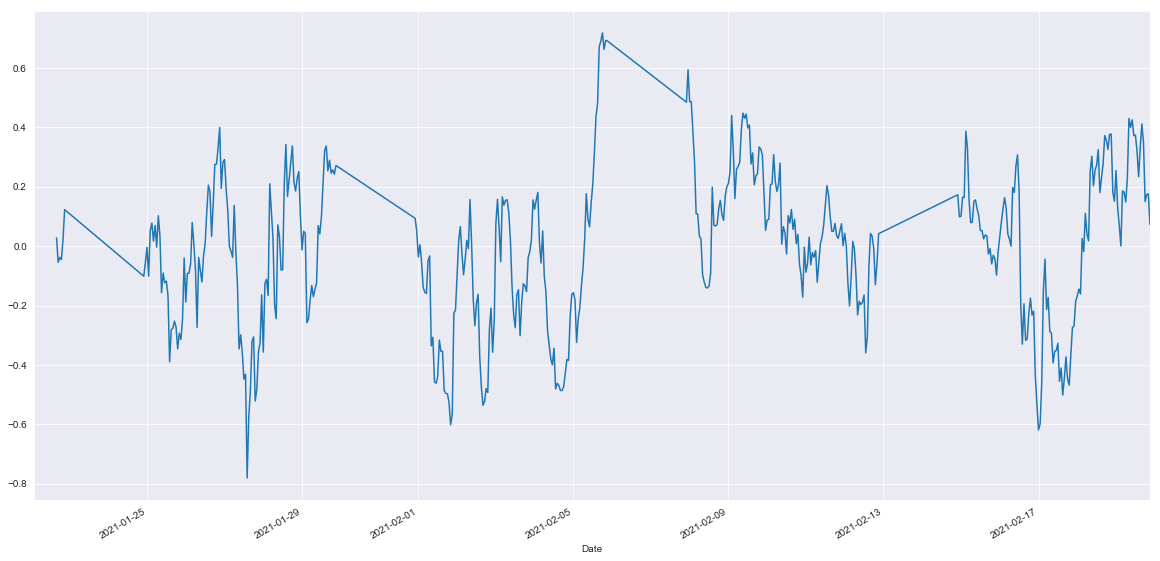

In [136]:
#candle_df["ROC"]=100*candle_df['close'].diff(14)/candle_df['close'][14:]
#candle_df.head(40)
TEST=100*candle_df['close'].diff(14)/candle_df['close'][14:]
TEST.plot(figsize=(20,10))

## Computing Aroon Indicator Values

In [137]:
candle_df['AroonUp']=aroon(candle_df,14,1)
candle_df['AroonDown']=aroon(candle_df,14,-1)

## Making and Plotting the CMO values

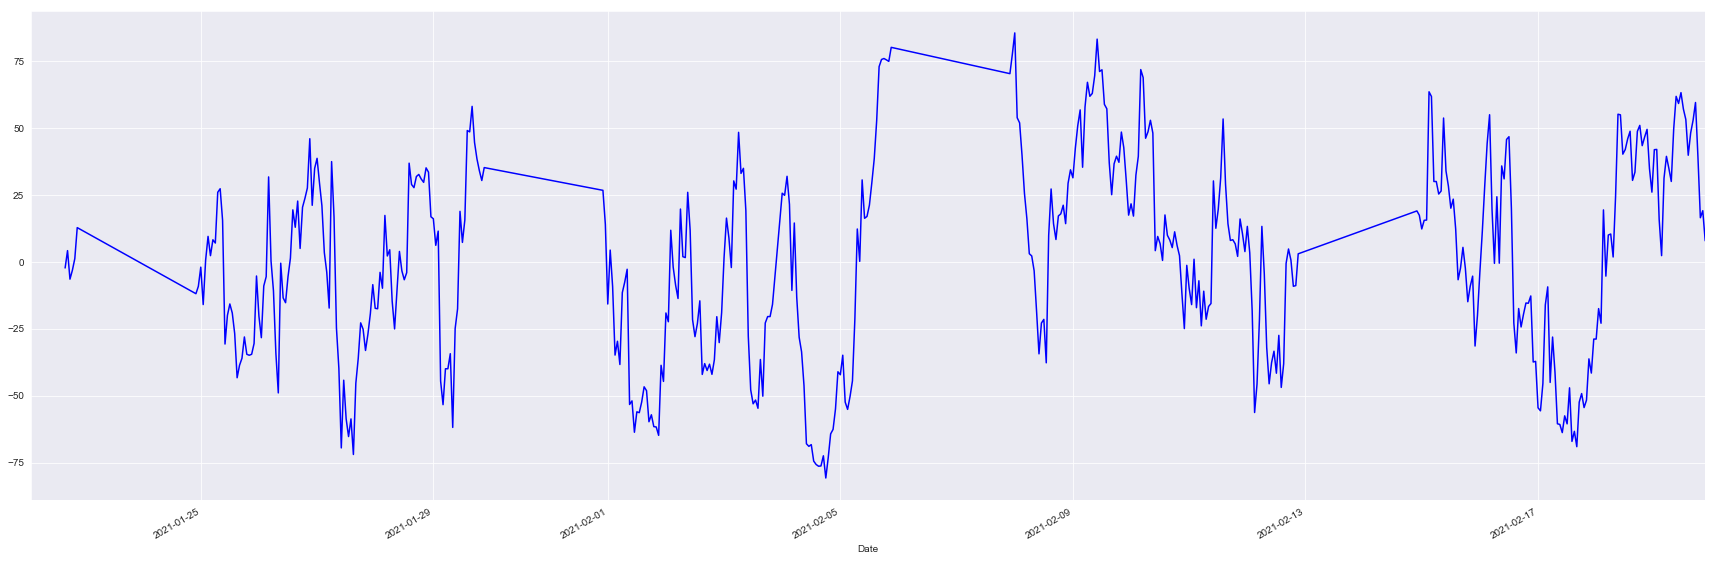

In [138]:
candle_df["cmo"]=cmo(candle_df,14)
candle_df["cmo"].plot(c="blue",figsize=(30,10))

## Plotting the ROC values

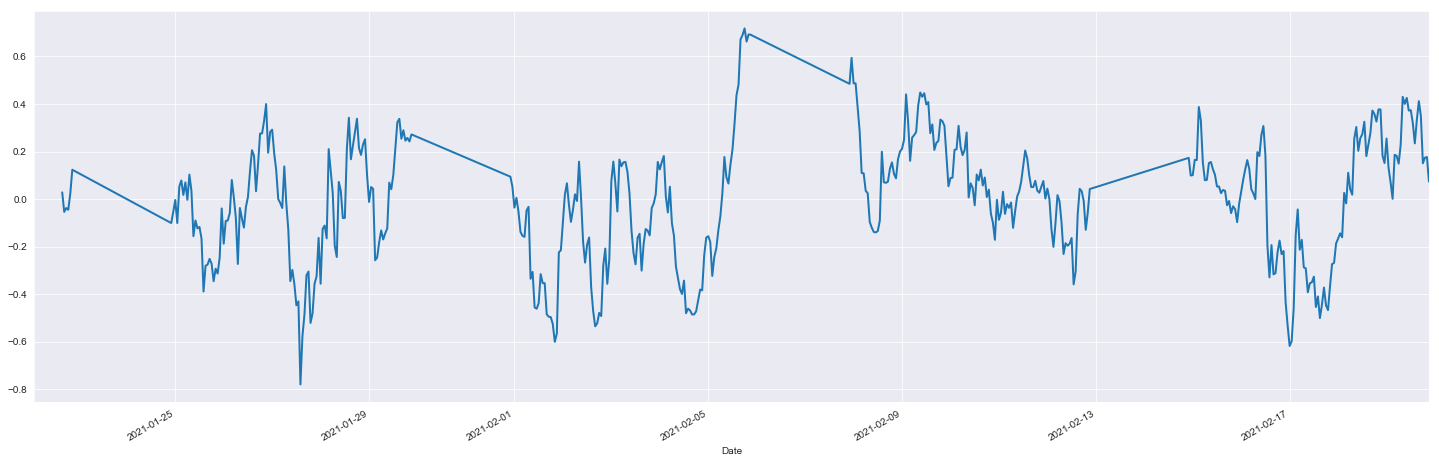

In [139]:
##############################             ROC FUNCTION          #######################################      
def ROC(df,p=14):
    """Takes in a dataframe of forex prices and computes the values of the ROC indictor for the specified period"""
    #p-value of the computational period
    ROC_df=100*df['close'].diff(p)/df['close'][p:]                              # constructing the ROC DataFrame
    return ROC_df                                                               # returning the ROC DataFrame
candle_df["ROC"]=ROC(candle_df)
candle_df["ROC"].plot(figsize=(25,8),linewidth=2)

In [140]:
candle_df['cross_signal']=0

In [141]:
candle_df=candle_df.reindex(labels=None, index=None, columns=["instrument","granularity","close","high","low","ROC","cross_signal","volume"])
candle_df.head(40)

,instrument,granularity,close,high,low,ROC,cross_signal,volume
Date,,,,,,,,
2021-01-22 02:00:00,EUR_USD,H1,1.21742,1.21760,1.21702,NaN,0,1967.0
2021-01-22 03:00:00,EUR_USD,H1,1.21738,1.21756,1.21712,NaN,0,1158.0
2021-01-22 04:00:00,EUR_USD,H1,1.21736,1.21768,1.21713,NaN,0,991.0
2021-01-22 05:00:00,EUR_USD,H1,1.21721,1.21746,1.21709,NaN,0,1037.0
2021-01-22 06:00:00,EUR_USD,H1,1.21654,1.21721,1.21630,NaN,0,2229.0
2021-01-22 07:00:00,EUR_USD,H1,1.21568,1.21652,1.21534,NaN,0,4631.0
2021-01-22 08:00:00,EUR_USD,H1,1.21800,1.21840,1.21516,NaN,0,7882.0
2021-01-22 09:00:00,EUR_USD,H1,1.21738,1.21896,1.21598,NaN,0,7761.0
2021-01-22 10:00:00,EUR_USD,H1,1.21684,1.21780,1.21662,NaN,0,4974.0


 ### Generate a Dual Moving Average Crossover Trading Signal

In [142]:
# Set the short window and long windows
short_window = 10
long_window = 30

#Creating Titles for MA columns in DataFrame
short_window_header=f"EMA{short_window}"
long_window_header=f"SMA{long_window}"
       
#candle_df2=candle_df['close'] 
# Set the `date` column as the index
#signals_df = signals_df.set_index("date", drop=True)                                #making date the index, drop column to avoid duplication

   # Generate the short and long moving averages (50 and 100 days, respectively)
candle_df[short_window_header] = candle_df["close"].ewm(short_window).mean()
candle_df[long_window_header] = candle_df["close"].rolling(long_window).mean()
candle_df["Signal"] = 0.0      # initializing the signal column of the DataFrame

 # Generate the trading signal 0 or 1,
# where 0 is when the EMA is under the SMA, and
# where 1 is when the EMA is higher (or crosses over) the SMA   (most likely a buy signal)
# start at the index value that is right after the 
candle_df["Signal"][short_window:] = np.where(
    candle_df[short_window_header][short_window:] > candle_df[long_window_header][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1 (Think about why this works)
candle_df["Entry/Exit"] = candle_df["Signal"].diff()



#candle_df.reindex(labels=None, index=None, columns=["Date","close"])
candle_df.head(30)

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,instrument,granularity,close,high,low,ROC,cross_signal,volume,EMA10,SMA30,Signal,Entry/Exit
Date,,,,,,,,,,,,
2021-01-22 02:00:00,EUR_USD,H1,1.21742,1.21760,1.21702,NaN,0,1967.0,1.217420,NaN,0.0,NaN
2021-01-22 03:00:00,EUR_USD,H1,1.21738,1.21756,1.21712,NaN,0,1158.0,1.217399,NaN,0.0,0.0
2021-01-22 04:00:00,EUR_USD,H1,1.21736,1.21768,1.21713,NaN,0,991.0,1.217385,NaN,0.0,0.0
2021-01-22 05:00:00,EUR_USD,H1,1.21721,1.21746,1.21709,NaN,0,1037.0,1.217335,NaN,0.0,0.0
2021-01-22 06:00:00,EUR_USD,H1,1.21654,1.21721,1.21630,NaN,0,2229.0,1.217144,NaN,0.0,0.0
2021-01-22 07:00:00,EUR_USD,H1,1.21568,1.21652,1.21534,NaN,0,4631.0,1.216838,NaN,0.0,0.0
2021-01-22 08:00:00,EUR_USD,H1,1.21800,1.21840,1.21516,NaN,0,7882.0,1.217055,NaN,0.0,0.0
2021-01-22 09:00:00,EUR_USD,H1,1.21738,1.21896,1.21598,NaN,0,7761.0,1.217111,NaN,0.0,0.0
2021-01-22 10:00:00,EUR_USD,H1,1.21684,1.21780,1.21662,NaN,0,4974.0,1.217068,NaN,0.0,0.0


In [143]:
#A_up=aroon(candle_df,20,1)
#A_down=aroon(candle_df,20,-1)
#A_down=aroon(candle_df,14,-1)
#candle_df['high']
len(candle_df)

500

## Making the CMO indicator

In [144]:
# Making the CMO function
def cmo(df,period=14):
    """Function computes the values for the CMO"""
    CMO =df['close'].copy()*0.0                                      # making an zero DataFrame
    for i in range(period,len(df)): 
        close_prices=df['close'][i-period:i]                 # getting necessary values of closing price
        A=close_prices.diff()
        SU=A[A.values>0].values.sum()                                # getting all positive  sums
        SD=A[A.values<0].values.sum()*-1                             # getting all negative sums
        CMO[i]=100*(SU-SD)/(SU+SD)                                       # computation of CMO value
    CMO[0:period]=np.NAN                                             # filling entries before period index with NAs
    return CMO                                                       # returning the vector of CMO values

## Placing a Market Order Trade

In [145]:
def PlaceTrade(pair, U, SL):
    """Used to place a trade for a given currency pair with user defined number of units and stopLoss
    pair: string representing currency pair
    U: number of units for trade
    SL: defined stopLoss"""
    from oandapyV20.contrib.requests import MarketOrderRequest            # For making market order requests
    mo=MarketOrderRequest(instrument=pair, units=U, stopLossOnFill=SL)    # passing necessary arguments to construct data payload for making market order
    r=orders.OrdeCreate(accountID,data=mo.data)                           # constructing market order using data payload
    rv=client.request(r)                                                  # submitting the market order
    TradeInfo=json.dumps(rv)
    tradeid=TradeInfo["orderFillTransaction"]["id"]                       # stores trade id for storage
    return tradeid.                                                       # returns the trade id
 

SyntaxError: invalid syntax (<ipython-input-145-df3dd27724d6>, line 12)

## For Modifying the StopLoss

In [146]:
def StopLossChange(ID,SL):
    """Function changes the stopLoss level for a given tradeID. StopLoss related to long or short position
    ID: the id of the trade whos stopLoss we are modifying
    SL: the new value of the stopLoss"""
    from oandapyV20.contrib.requests import StopLossOrderRequest         # importing the class used for stoploss orders
    ordr=StopLossOrderRequest(tradeID=ID,priace=SL)                      # making data payload for stoploss request
    r=orders.OrderCreate(accountID,data=ordr.data)                       # constructing stoploss order with data payload
    
    rv=client.request(r)                                                 # making the request for stoploss change
    tradeInfo=json.dumps(rv)                                             # getting the trade info

## For Closing a Trade

In [147]:
def TradeClose(ID):
    """Function closes the trade associated with the provided user ID
    ID: tradeID of position to close"""
    from oandapyV20.contrib.requests import TradeCloseRequest            # importing class used for closing trades
    ordr=TradeCloseRequest(units="ALL")
    r=trades.TradeClose(accountID,tradeID=ID,data=ordr.data)             # constructing trade for request
    rv=client.request(r)                                                 # making request to close trade  
    
    
    
    """Also, look into using the PositionClose class to do this, where
    you would only need the name of the instrument and the number of 
    units that you'd like to closeo"""

## Obtaining All Open Positions for the Account

In [ ]:
def get_OpenTrades():
    """Function returns dictionary of information on all open trades.
    Inside the dictionary, you will need to access 'positions' and within
    positions, you can cycle through trades using a loop"""
    import oandapyV20.endpoints.positions as positions                   # imports class needed for getting open trade info
    r=positions.OpenPositions(accountID=accountID)                       # constructs request to get open trade info
    open_trades_dictionary=client.request(r)                             # makes request to get info on open trades
    return(open_trades)                                                  # returns dictionary of info on open trades



    ### Look into using the OpenTrades class to do the same thing. The
    ### output looks a lot cleaner; would allow you to extract tradeID,
    ### check if units are positive or negative, obtain current price
    ### using some math on price and unrealized profit
    
    
    ### Trade only the most liquid pairs. Once those are mastered, then begin to 
    ### look at how to trade some of the other pairs. By trading a specific set
    ### of pairs, we don't have to read all possible trading pairs, checking 
    ### if spreads are agreeable, and then looking for trades

## Check Open Positions to See if They Need to Be Closed

In [ ]:
def PositionCheck(open_trades_dictionary):           #what will be the closing criteria?
    """function takes dictionary of open trade info, and checks if each position needs
    to be closed based on closing criteria"""
    for trade in open_trades_dictionary["positions"]:                    # loop for cycling through open positions
        print(trade.keys())                                              # this command prints the keys used in describing each trade

## Checking if Trade is Ready to Be Closed

In [24]:
def CloseCheck(pair,pos):
    """Function checks to see if trade on current currency pair needs to be closed.
    The strategy is to see if there is a particular cross of moving averages. The particular
    type of cross we're looking for will depend if we have a long or short position"""
    
    # Get candlesticks
    # compute moving average values
    # check for cross of moving averages, depending on long or short position
    # make a function called "CleanCandles" that gets you all the information that you need
    return pair

In [59]:
# goal is to get open trade pair symbols as a set, then for each of the tradable pairs, see if that symbol is in the list of open trades
# This vector will be passed into a TradeCheck function, which will determine if there is a buy or sell opportunity for the given pair

# Simple way to see if a tradable pair is in the list pairs with open positions (Turn this into a nice function perhaps, to get rid of lines; call it PairCheck)
open_trade_pairs=["USD_JPY","EUR_USD"]
Pair_Check=[pair for pair in list_of_pairs if (pair not in open_trade_pairs)]
Pair_Check                                                                                       #displaying pairs that don't have positions open on them

# Constructing the LSTM NN Model

## Constructing the Window Function

In [22]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

## Setting Values for Window Function

In [23]:
# Creating the features (X) and target (y) data using the window_data() function.
# the 2nd column is the close price for the asset
window_size = 3                                                                 # window size of 7 days (can adjust for different results)                                                                    # defining the column where you want to extract features
feature=2                                                                       # specifying the feature column
target_column = 2                                                               # defining the column where you want to extract targets
X, y = window_data(candle_df, window_size, feature, target_column)                     # splitting DataFrame into features and targets
X.shape                                                                         # gives shape of feature DataFrame

(497, 3)

## Splitting the Data

In [17]:
# Manually splitting the data
split = int(0.8 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

# Standardizing the Closing Price Data

In [24]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()  

# Create a MinMaxScaler object
#scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
#scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Fit the MinMaxScaler object with the target data Y
#scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

TypeError: float() argument must be a string or a number, not 'dict'

## Reshaping the Data

In [19]:
# Reshaping training data: Dimension representations=(samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Reshaping testing data: Dimension representations=(samples, time steps, features)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(100, 3, 1)

In [153]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, AveragePooling1D, MaxPool1D 

### Constructing the LSTM Model

In [154]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 80
dropout_fraction = 0.1

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

model.add(Flatten())
# Output layer
model.add(Dense(1))

## Compiing LSTM NN Model

In [155]:
# Compile the model (Don't forget an accuracy score)
model.compile(optimizer="adam", loss="mean_squared_error", metrics="mean_squared_error")

## Getting a Summary of the Model

In [156]:
# Show the model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 3, 80)             26240     
_________________________________________________________________
dropout_15 (Dropout)         (None, 3, 80)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 3, 80)             51520     
_________________________________________________________________
dropout_16 (Dropout)         (None, 3, 80)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_17 (Dropout)         (None, 80)                0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 80)              

## Training the Model

In [157]:
# Train the model
model.fit(X_train, y_train, epochs=15, shuffle=False, batch_size=90, verbose=1)

Epoch 1/15
5/5 [==============================] - 6s 23ms/step - loss: 1.0459 - mean_squared_error: 1.0459
Epoch 2/15
5/5 [==============================] - 0s 28ms/step - loss: 0.9636 - mean_squared_error: 0.9636
Epoch 3/15
5/5 [==============================] - 0s 26ms/step - loss: 0.8687 - mean_squared_error: 0.8687
Epoch 4/15
5/5 [==============================] - 0s 26ms/step - loss: 0.7250 - mean_squared_error: 0.7250
Epoch 5/15
5/5 [==============================] - 0s 36ms/step - loss: 0.5130 - mean_squared_error: 0.5130
Epoch 6/15
5/5 [==============================] - 0s 21ms/step - loss: 0.2626 - mean_squared_error: 0.2626
Epoch 7/15
5/5 [==============================] - 0s 30ms/step - loss: 0.0853 - mean_squared_error: 0.0853
Epoch 8/15
5/5 [==============================] - 0s 22ms/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 9/15
5/5 [==============================] - 0s 47ms/step - loss: 0.0856 - mean_squared_error: 0.0856
Epoch 10/15
5/5 [====================

## Evaluating the Model

In [158]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=2)

4/4 - 1s - loss: 0.1426 - mean_squared_error: 0.1426


[0.1426372528076172, 0.1426372528076172]

### Making Predictions

In [159]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)
X_test.shape

(100, 3, 1)

In [160]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

## Make DataFrame of Real and Predicted Prices

In [161]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = candle_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
Date,,
2021-02-15 18:00:00,1.21312,1.213060
2021-02-15 19:00:00,1.21308,1.213196
2021-02-15 20:00:00,1.21310,1.212919
2021-02-15 21:00:00,1.21280,1.212922
2021-02-15 22:00:00,1.21281,1.212891


## Plotting the Real and Predicted Prices

In [162]:
A_diff=stocks['Actual'].diff()
P_diff=stocks['Predicted'].diff()
Trades=A_diff*P_diff


title_statement=f" POCKETBOT=> Trades won: {sum(A_diff*P_diff>0)}\n Trade lost:{sum(A_diff*P_diff<0)}"

# Visualize close price for the investment
A = stocks[['Actual']].hvplot(
    line_color='blue',
    ylabel='Value',
    width=1000,
    height=400,
    title=title_statement
)

# Scatter Plot of Trades Won
wins = stocks[['Actual']][Trades>0].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)



# Scatter Plot of Trades Lost
losses = stocks[['Actual']][Trades<0].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)


# Visualize moving averages
P = stocks[['Predicted']].hvplot(
    ylabel='Value',
    width=1000,
    height=400
)

print("Trades won: "+str(sum(A_diff*P_diff>0)))
print("Trades lost: "+str(sum(A_diff*P_diff<0)))


# Overlay plots
entry_exit_plot = A*P*wins*losses
entry_exit_plot.opts(xaxis=None)

Trades won: 44
Trades lost: 54


:Overlay
   .Curve.I    :Curve   [Date]   (Actual)
   .Curve.II   :Curve   [Date]   (Predicted)
   .Scatter.I  :Scatter   [Date]   (Actual)
   .Scatter.II :Scatter   [Date]   (Actual)

### MAKING SIMULATIONS FOR LSTM NN MODEL

In [81]:
# Plot the real vs predicted prices as a line chart
#stocks.plot(title="Actual Vs. Predicted EUR_USD Prices")
counter=0
iterations=10
amount=250         # initial funding amount
return_percent=.85
trade=5
final_amounts=[]

for i in range(iterations):
    amount=250  #reinitialze starting amount
    model.fit(X_train, y_train, epochs=100, shuffle=False, verbose=0,batch_size=90) 
    
    predicted = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
    stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = candle_df.index[-len(real_prices): ]) 


    A_diff=stocks['Actual'].diff()
    P_diff=stocks['Predicted'].diff()
    Trades=A_diff*P_diff

    W=sum(A_diff*P_diff>0)
    L=sum(A_diff*P_diff<0)
    amount+=(W*trade*return_percent-L*trade)
    if (W>L):
        counter+=1.    #update counter
        
# Proportion of winning trades:
    final_amounts.append([W,L])
result=f"Results from {iterations} Trades: Profitability Rate: {counter/iterations}"
print(result)
print(final_amounts)
# Plot the real vs predicted prices as a line chart
#stocks2.plot(title="Actual Vs. Predicted EUR_USD Prices",figsize=(20,10))

Wtotal=counter                             # gets total number of wins
Ltotal=iterations-counter                  # gets total number of losses

# Printing the Results
pd.DataFrame({'Loss':Ltotal,'Win':Wtotal},index=["outcome"]).plot(kind='bar',title=result,figsize=(20,10),color=["red","green"])

KeyboardInterrupt: 

## Defining Conv2D NN

In [82]:
def basic_conv2D(n_filters=24, fsize=5, window_size=5, n_features=1):
    import tensorflow as tf  
    new_model = tf.keras.Sequential()
    # Hypothetically, we could also tune the padding and activation here.
    new_model.add(tf.keras.layers.Conv2D(2*n_filters, (1,fsize), padding="same", activation="relu", input_shape=(window_size, n_features, 1)))
    #new_model.add(tf.keras.layers.MaxPooling2D((3, 3),padding='same'))
    # Flatten will take our convolution filters and lay them out end to end so our dense layer can predict based on the outcomes of each
    new_model.add(tf.keras.layers.Conv2D(n_filters, (1,fsize), padding="same", activation="linear", input_shape=(window_size, n_features, 1)))
    new_model.add(tf.keras.layers.Flatten())                                                              # flattening layer                                           
    new_model.add(tf.keras.layers.Dense(1500, activation='relu'))                                         # Dense layer for learning
    new_model.add(tf.keras.layers.Dense(500))                                                             # Denser layer for learning
    new_model.add(tf.keras.layers.Dense(250,activation='relu'))                                                             # Denser layer for learning
    new_model.add(tf.keras.layers.Dense(1))                                                               # single ouput layer 
    new_model.compile(optimizer="adam", loss="mean_absolute_error")                                        # defining optimizer and loss function
    return new_model       

## Defining Conv 1D NN

In [168]:
def basic_conv1D(n_filters=30, fsize=5, window_size=5, n_features=2):
    new_model = Sequential()
    new_model.add(Conv1D(n_filters, fsize, padding="same", activation="relu", input_shape=(window_size, n_features)))
    new_model.add(MaxPool1D(pool_size=3, strides=2, padding='same'))
    new_model.add(Conv1D(n_filters, fsize, padding="same", activation="relu", input_shape=(window_size, n_features)))
    new_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))
    #new_model.add(Conv1D(n_filters, fsize, padding="same", activation="relu", input_shape=(window_size, n_features)))
    #new_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))
 # Flatten will take our convolution filters and lay them out end to end so our dense layer can predict based on the outcomes of each
    new_model.add(Flatten())
    new_model.add(Dense(1800, activation="relu"))
    new_model.add(Dense(100))
    new_model.add(Dense(1))
    new_model.compile(optimizer="adam", loss="mean_squared_error",metrics="mean_squared_error") 
    return new_model

## Constructing and Compiling the Model

In [164]:
univar_model = basic_conv1D(n_filters=128, fsize=5, window_size=window_size, n_features=X_train.shape[2])
univar_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 3, 128)            768       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1800)              232200    
_________________________________________________________________
dense_28 (Dense)             (None, 100)             

## Fitting the Model

# CREATED LOOP TO TEST MODEL EFFICIENCY: BEST SO FAR (0.656)

In [21]:
counter=0
iterations=10
amount=250         # initial funding amount
return_percent=.85
trade=5
final_amounts=[]

for i in range(iterations):
    amount=250.  #reinitialze starting amount
    univar_model.fit(X_train, y_train, epochs=100, shuffle=False, verbose=0,batch_size=90) 
    
    predicted2 = univar_model.predict(X_test)
    predicted_prices2 = scaler.inverse_transform(predicted2)
    real_prices2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
    stocks2 = pd.DataFrame({
    "Actual": real_prices2.ravel(),
    "Predicted": predicted_prices2.ravel()
    }, index = candle_df.index[-len(real_prices2): ]) 


    A_diff=stocks2['Actual'].diff()
    P_diff=stocks2['Predicted'].diff()
    Trades=A_diff*P_diff

    W=sum(A_diff*P_diff>0)
    L=sum(A_diff*P_diff<0)
    amount+=(W*trade*return_percent-L*trade)
    if (W>L):
        counter+=1.    #update counter
        
# Proportion of winning trades:
    final_amounts.append([W,L])
result=f"Results from {iterations} Trades: Profitability Rate: {counter/iterations}"
print(result)
print(final_amounts)
# Plot the real vs predicted prices as a line chart
#stocks2.plot(title="Actual Vs. Predicted EUR_USD Prices",figsize=(20,10))

Wtotal=counter                             # gets total number of wins
Ltotal=iterations-counter                  # gets total number of losses

# Printing the Results
pd.DataFrame({'Loss':Ltotal,'Win':Wtotal},index=["outcome"]).plot(kind='bar',title=result,figsize=(20,10),color=["red","green"])


NameError: name 'univar_model' is not defined

In [165]:
hist=univar_model.fit(X_train, y_train, epochs=100, shuffle=False, verbose=1,batch_size=20)  

Epoch 1/100
20/20 [==============================] - 1s 5ms/step - loss: 0.7722 - mean_squared_error: 0.7722
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5957 - mean_squared_error: 0.5957
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5200 - mean_squared_error: 0.5200
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3433 - mean_squared_error: 0.3433
Epoch 5/100
20/20 [==============================] - 0s 12ms/step - loss: 0.4554 - mean_squared_error: 0.4554
Epoch 6/100
20/20 [==============================] - 0s 9ms/step - loss: 0.6665 - mean_squared_error: 0.6665
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 0.2171 - mean_squared_error: 0.2171
Epoch 8/100
20/20 [==============================] - 0s 12ms/step - loss: 0.1711 - mean_squared_error: 0.1711
Epoch 9/100
20/20 [==============================] - 0s 14ms/step - loss: 0.2913 - mean_squared_error: 0.2913
Epoch 10/100
20/

In [20]:
predicted2 = univar_model.predict(X_test)

predicted_prices2 = scaler.inverse_transform(predicted2)
real_prices2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
stocks2 = pd.DataFrame({
    "Actual": real_prices2.ravel(),
    "Predicted": predicted_prices2.ravel()
}, index = candle_df.index[-len(real_prices2): ]) 

# Show the DataFrame's head



# Plot the real vs predicted prices as a line chart
#stocks2.plot(title="Actual Vs. Predicted EUR_USD Prices",figsize=(20,10))


NameError: name 'univar_model' is not defined

In [167]:


A_diff=stocks2['Actual'].diff()
P_diff=stocks2['Predicted'].diff()
Trades=A_diff*P_diff


title_statement=f" POCKETBOT=> Trades won: {sum(A_diff*P_diff>0)}\n Trade lost:{sum(A_diff*P_diff<0)}"

# Visualize close price for the investment
A = stocks2[['Actual']].hvplot(
    line_color='blue',
    ylabel='Value',
    width=1000,
    height=400,
    title=title_statement
)

# Scatter Plot of Trades Won
wins = stocks2[['Actual']][Trades>0].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)



# Scatter Plot of Trades Lost
losses = stocks2[['Actual']][Trades<0].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)


# Visualize moving averages
P = stocks2[['Predicted']].hvplot(
    ylabel='Value',
    width=1000,
    height=400
)

print("Trades won: "+str(sum(A_diff*P_diff>0)))
print("Trades lost: "+str(sum(A_diff*P_diff<0)))


# Overlay plots
entry_exit_plot = A*P*wins*losses
entry_exit_plot.opts(xaxis=None)

Trades won: 51
Trades lost: 47


:Overlay
   .Curve.I    :Curve   [Date]   (Actual)
   .Curve.II   :Curve   [Date]   (Predicted)
   .Scatter.I  :Scatter   [Date]   (Actual)
   .Scatter.II :Scatter   [Date]   (Actual)

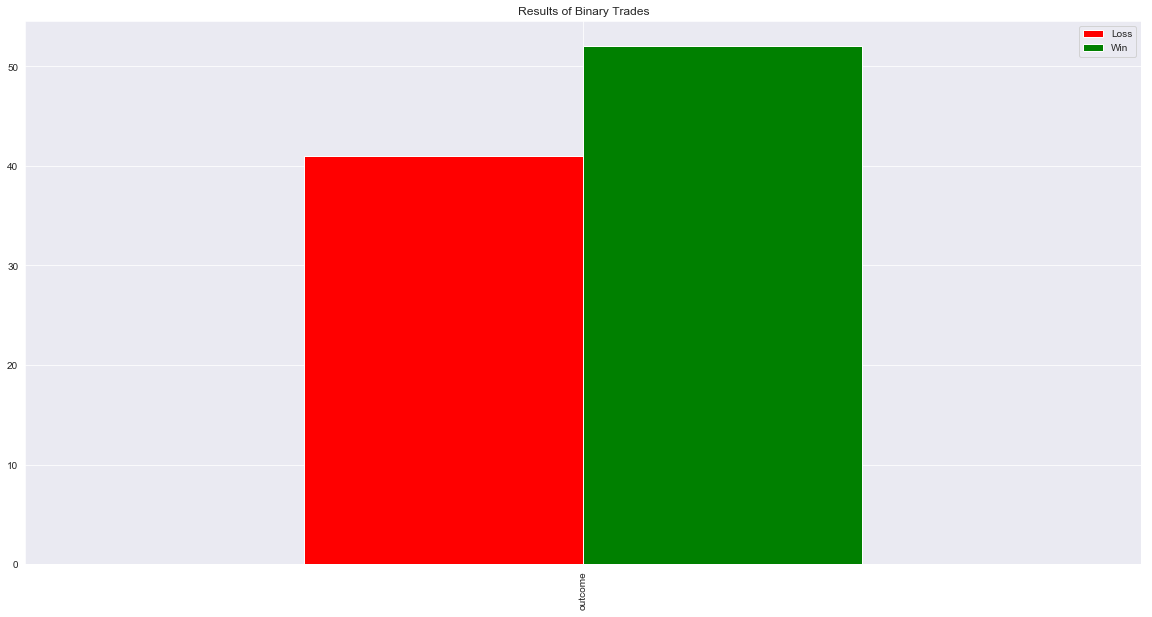

In [357]:
#univar_model.predict(S)
#univar_model.predict(S.reshape((5,1,1)))
#X_test[-1].shape

W=sum(A_diff*P_diff>0)
L=sum(A_diff*P_diff<0)
pd.DataFrame({'Loss':L,'Win':W},index=["outcome"]).plot(kind='bar',title="Results of Binary Trades",figsize=(20,10),color=["red","green"])